Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from glob import glob
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [2]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
# The following code loads the training dataset from a directory, 
# splits the data into training and validation sets, resizes images, 
# and groups them into batches for model training.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [6]:
# The following code loads the validation dataset from a directory, 
# ensuring a 20% split from the training data, resizes images, 
# and groups them into batches for model validation.

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                     # Path to the train images (same as training directory)
    validation_split=0.2,               # 20% of data for validation
    subset="validation",                # Specify this is for validation set
    seed=123,                           # Seed for reproducibility
    image_size=(img_height, img_width), # Resize images to 180x180
    batch_size=batch_size               # Use batch size of 32
)


Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

2024-11-20 21:03:49.533298: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


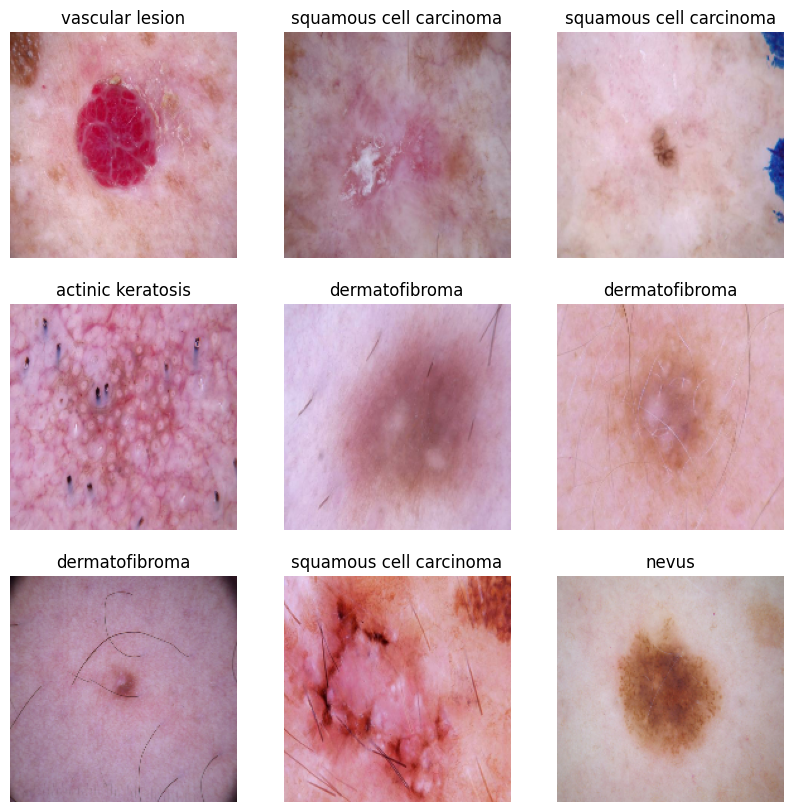

In [8]:
# Plotting a batch of images from the training dataset

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  
        plt.title(class_names[labels[i]])  # Displaying the class name as title
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [10]:
# The following code defines a Convolutional Neural Network (CNN) model for classifying skin cancer images.
# The model consists of three convolutional blocks with pooling layers, followed by a flatten layer and fully connected layers.
# The model also includes a dropout layer to help reduce overfitting.
# The final output layer uses softmax activation to classify images into one of the 9 classes.

input_shape = (img_height, img_width, 3)

# Create the model
model = Sequential([
    # Input layer
    layers.Input(shape=input_shape),

    # Rescaling layer to normalize pixel values between [0, 1]
    layers.Rescaling(1./255),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten layer
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.7),  # To reduce overfitting
    layers.Dense(9, activation='softmax')  # Output layer with 9 classes
])


### Compile the model

In [11]:
# The following code configures the model's optimizer and compilation settings.
# A custom learning rate is set for the Adam optimizer to control the model's learning rate during training.
# The model is compiled using the Adam optimizer, sparse categorical cross-entropy loss as this is a multi-class classification problem

learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 101s 340ms/step - accuracy: 0.1528 - loss: 2.1551 - val_accuracy: 0.3427 - val_loss: 1.7958
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 136s 486ms/step - accuracy: 0.2832 - loss: 1.8638 - val_accuracy: 0.4433 - val_loss: 1.5816
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 132s 468ms/step - accuracy: 0.3444 - loss: 1.7181 - val_accuracy: 0.5002 - val_loss: 1.5074
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 89s 316ms/step - accuracy: 0.3744 - loss: 1.6469 - val_accuracy: 0.5122 - val_loss: 1.4791
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 91s 323ms/step - accuracy: 0.3935 - loss: 1.5951 - val_accuracy: 0.5607 - val_loss: 1.3158
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 87s 308ms/step - accuracy: 0.4354 - loss: 1.4890 - val_accuracy: 0.5768 - val_loss: 1.2529
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 88s 315ms/step - accuracy: 0.4381 - loss: 1.4667 - val_accuracy: 0.5843 - val_loss: 1.2165
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 89s 317ms/step - accuracy: 0.4635 - loss

### Visualizing training results

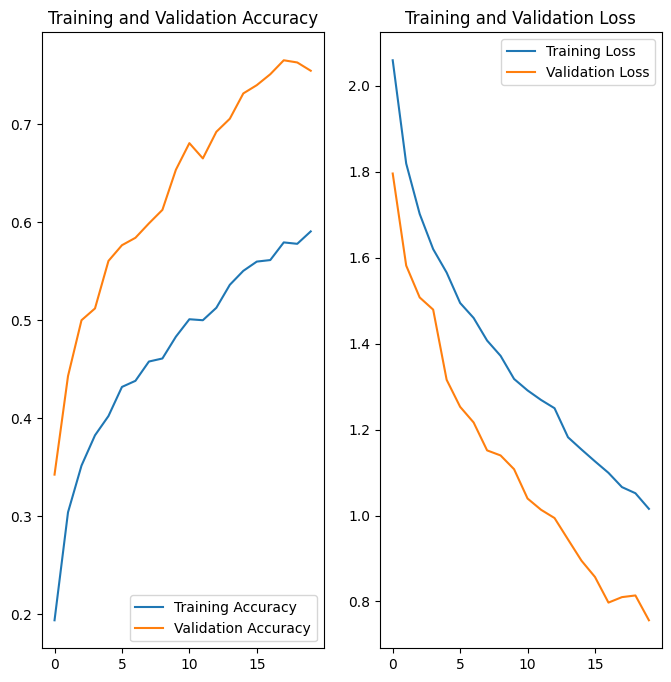

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Findings from model training

**Training Performance:** Training accuracy improved from 15.3% to 59.4%, and training loss decreased from 2.16 to 1.01, indicating learning progress.

**Validation Performance:** Validation accuracy increased from 34.3% to 75.5%, while validation loss decreased from 1.80 to 0.76. However, validation accuracy lags behind training accuracy.


# Evidence of Overfitting or Underfitting:

**Underfitting:** Early epochs showed low accuracy and high loss, indicating underfitting at the start.

**Overfitting:** The gap between training and validation accuracy and fluctuating validation loss suggest overfitting.



In [15]:
# The following code defines the data preprocessing and augmentation strategy for training and validation data.
# 
# - **Training Data Augmentation**: The `ImageDataGenerator` is used to apply various transformations (rotation, width/height shift, shear, zoom, etc.) to the training images. These transformations help create more varied data to improve model generalization.
# - **Validation Data**: The validation data is only rescaled (without augmentation), as we want to evaluate the model's performance on real, unaltered images.
# 


# Define the ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalize pixel values to [0, 1]
    rotation_range=20,              # Random rotation
    width_shift_range=0.2,          # Randomly shift width
    height_shift_range=0.2,         # Randomly shift height
    shear_range=0.1,                # Random shear transformation
    zoom_range=0.1,                 # Random zoom
    horizontal_flip=False,          # Randomly flip images horizontally
    vertical_flip=False,            # Randomly flip images vertically
    fill_mode='nearest'             # Fill pixels with the nearest value
)


val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the training and validation data generators
train_generator = train_datagen.flow_from_directory(
    data_dir_train,           # Path to training data directory
    target_size=(img_height, img_width),  
    batch_size=batch_size,          
    class_mode='sparse',            
    shuffle=True                    
)

val_generator = val_datagen.flow_from_directory(
    data_dir_test,             # Path to validation data directory
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)


Found 11239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


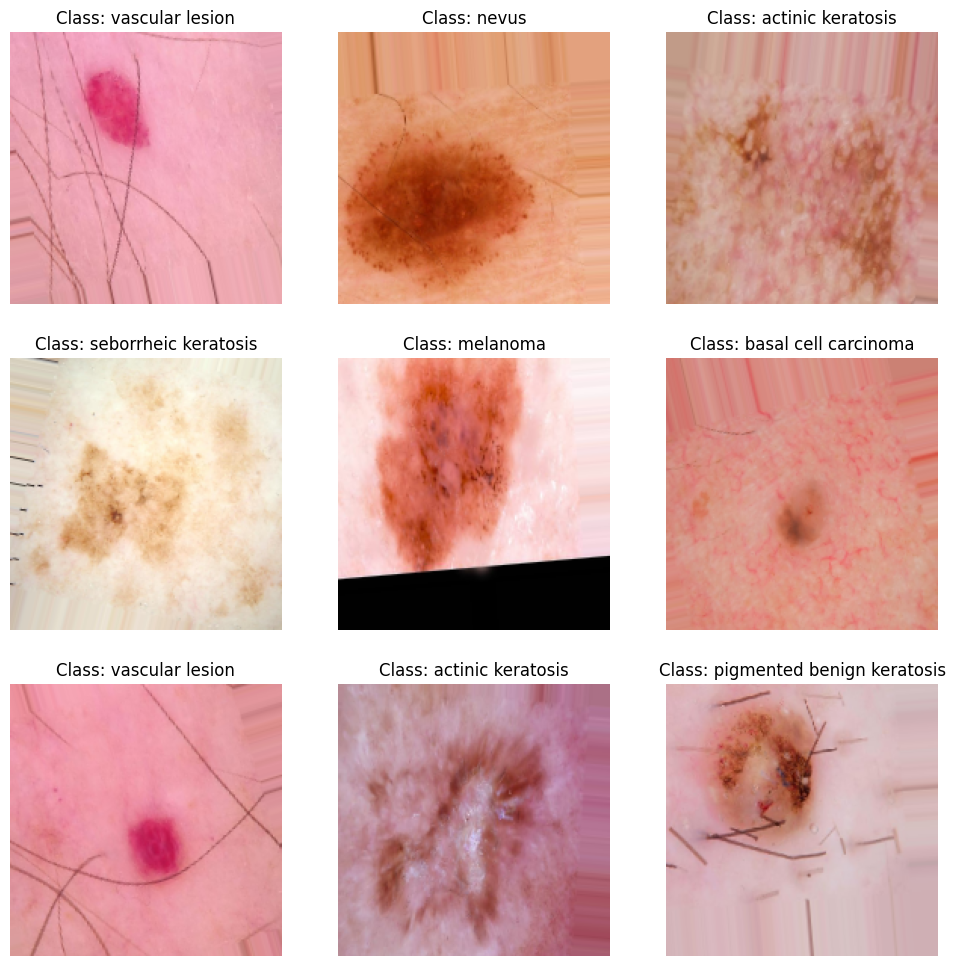

In [17]:
# The following code visualizes a batch of augmented training images.

images, labels = next(train_generator)

plt.figure(figsize=(12, 12))

num_images = 9
for i in range(num_images):
    plt.subplot(3, 3, i + 1)  # 3x3 grid
    plt.imshow(images[i])
    plt.title(f"Class: {class_names[int(labels[i])]}")
    plt.axis('off')

plt.show()

### Create the model


In [18]:
# The following code builds a Convolutional Neural Network (CNN) for multi-class classification (9 classes in total).
# - The model consists of multiple convolutional layers followed by max pooling and dropout layers for regularization.
# - Dropout layers are included to prevent overfitting by randomly dropping a percentage of the nodes during training.
# - The final output layer has 9 neurons (one for each class) with softmax activation to predict probabilities for each class.

model = Sequential([
    # Input layer
    Input(shape=(img_height, img_width, 3)),

    # Rescaling layer to normalize pixel values between [0, 1]
    layers.Rescaling(1./255),

    # First convolutional layer with 32 filters and ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout layer with 20% drop rate

    # Second convolutional layer with 64 filters and ReLU activation
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    # Third convolutional layer with 128 filters and ReLU activation
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    # Flattening output
    layers.Flatten(),

    # Fully connected layer with 128 neurons and ReLU activation
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),  # Dropout layer with 50% drop rate

    layers.Dense(9, activation='softmax')
])


### Compiling the model

In [19]:
# The following code configures the model's optimizer and compilation settings.
# A custom learning rate is set for the Adam optimizer to control the model's learning rate during training.
# The model is compiled using the Adam optimizer, sparse categorical cross-entropy loss as this is a multi-class classification problem

learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs
)

/Users/anilnarayanan/Library/Caches/pypoetry/virtualenvs/melanoma_assisgnment-tb4PdnbT-py3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 106s 298ms/step - accuracy: 0.1229 - loss: 2.1958 - val_accuracy: 0.1356 - val_loss: 2.1844
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 104s 294ms/step - accuracy: 0.1288 - loss: 2.1923 - val_accuracy: 0.1356 - val_loss: 2.1844
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 106s 299ms/step - accuracy: 0.1334 - loss: 2.1930 - val_accuracy: 0.1356 - val_loss: 2.1820
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.1255 - loss: 2.1915 - val_accuracy: 0.1356 - val_loss: 2.1825
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 101s 286ms/step - accuracy: 0.1334 - loss: 2.1861 - val_accuracy: 0.2881 - val_loss: 2.1204
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 102s 289ms/step - accuracy: 0.1886 - loss: 2.1264 - val_accuracy: 0.2712 - val_loss: 2.0721
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 104s 294ms/step - accuracy: 0.1974 - loss: 2.0822 - val_accuracy: 0.2797 - val_loss: 2.0348
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 102s 289ms/step - accuracy: 0.2120 - lo

### Visualizing the results

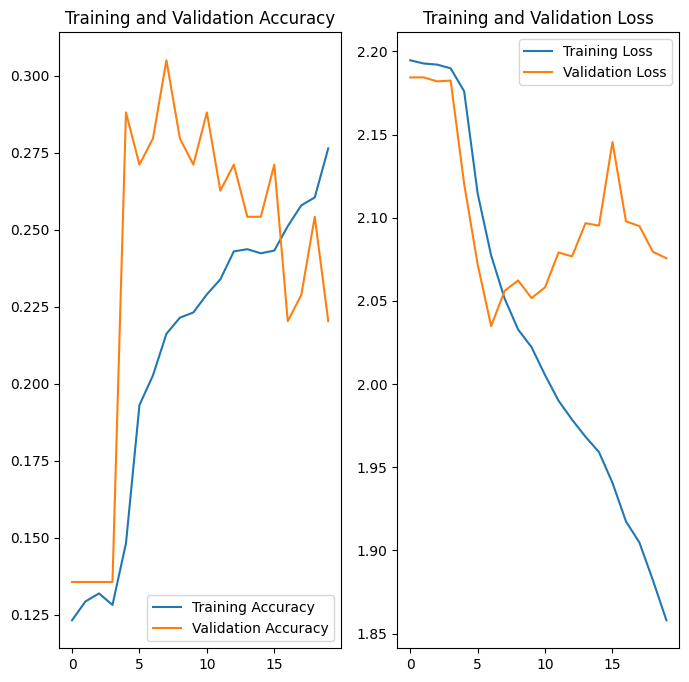

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:

1. **Model Performance:**
   - Training accuracy increased from 12.29% to 27.94%, but validation accuracy remained low (22-29%) with no improvement.
   - Validation loss showed little change and even increased, indicating poor generalization.


2. **Overfitting vs Underfitting:**
   - **Underfitting:** Both training and validation accuracies are low, implying the model is not learning well.
   - **No Overfitting:** No significant gap between training and validation performance, so overfitting isn't evident.


3. **Improvement Over Previous Model:**
   - The model fails to generalize well to validation data.


#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
# This block calculates and prints the distribution of samples across different classes in the training dataset.

class_indices = train_generator.class_indices  # Mapping of class names to indices
class_labels = list(class_indices.keys())  # Get the class names

# Distribution of samples per class
class_counts = train_generator.classes
class_distribution = {class_labels[i]: (class_counts == i).sum() for i in range(len(class_labels))}

print("Class Distribution in Training Dataset:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count}")


Class Distribution in Training Dataset:
actinic keratosis: 1114
basal cell carcinoma: 1376
dermatofibroma: 1095
melanoma: 1438
nevus: 1357
pigmented benign keratosis: 1462
seborrheic keratosis: 1077
squamous cell carcinoma: 1181
vascular lesion: 1139


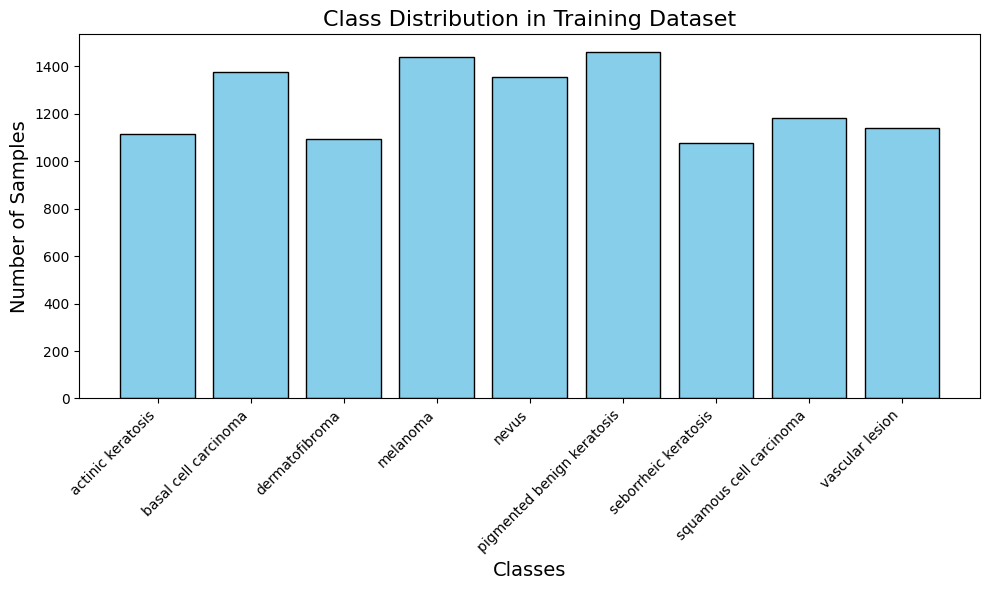

In [23]:
# This block visualizes the distribution of samples across different classes in the training dataset using a bar chart.

classes = list(class_distribution.keys())
counts = list(class_distribution.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in Training Dataset", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.tight_layout()

plt.show()

## Findings

#### - Which class has the least number of samples?
Seborrheic Keratosis has the least number of samples with 1077.

#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented Benign Keratosis (1462 samples) and Melanoma (1438 samples) dominate the dataset in terms of the number of samples. These two classes have the highest counts.

#### Observations:
The dataset shows some class imbalance, with classes like Seborrheic Keratosis having fewer samples and classes like Pigmented Benign Keratosis and Melanoma having significantly more.



##  Rectify the class imbalance

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset=pathlib.Path("/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17814F450>: 100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 364.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x178284810>: 100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 389.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x178201490>: 100%|███████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 379.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x178203C10>: 100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 90.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x3B81B0950>: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 90.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3B82A5610>: 100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 323.23 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3B82034D0>: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 178.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17811FED0>: 100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 360.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3B9104290>: 100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 287.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010364.jpg_4958e419-df0d-4919-ba60-fe6ad7c505a0.jpg',
 '/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010049.jpg_64a21576-d9ee-42c2-94f3-835b9879d52a.jpg',
 '/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000511.jpg_26d2d190-7224-42f4-8967-d34344d8d748.jpg',
 '/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009927.jpg_86332d33-3492-469a-afb1-80624dfaffd1.jpg',
 '/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [31]:
new_df['Label'].value_counts()

Label
melanoma                      1500
pigmented benign keratosis    1500
nevus                         1500
basal cell carcinoma          1500
actinic keratosis             1500
squamous cell carcinoma       1500
vascular lesion               1500
seborrheic keratosis          1500
dermatofibroma                1500
Name: count, dtype: int64

Added 1500 images to all the classes to maintain some class balance.

### Training the model

In [32]:
batch_size = 32
img_height = 180
img_width = 180

### Training dataset

In [33]:
data_dir_train="/Users/anilnarayanan/Documents/Upgrad/Melanoma Assisgnment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


### Validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


### Create the model

In [35]:
# This model is a Convolutional Neural Network (CNN) designed for multi-class classification. It consists of:
# 1. Convolutional layers (Conv2D) for feature extraction with BatchNormalization and ReLU activation functions.
# 2. MaxPooling layers for downsampling.
# 3. Dropout layers to prevent overfitting.
# 4. Fully connected Dense layer for classification.
# 5. The final output layer uses Softmax activation to classify the input into one of 9 classes.


model = Sequential([
    # Input layer
    Input(shape=(img_height, img_width, 3)),

    # Rescaling layer to normalize pixel values between [0, 1]
    layers.Rescaling(1./255),

    # First convolutional layer with 32 filters and ReLU activation
    layers.Conv2D(32, (3, 3), activation=None),
    layers.BatchNormalization(),  # Batch Normalization after Conv2D
    layers.ReLU(),  # ReLU activation function
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout layer with 20% drop rate

    # Second convolutional layer with 64 filters and ReLU activation
    layers.Conv2D(64, (3, 3), activation=None),  
    layers.BatchNormalization(),  
    layers.ReLU(),  
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  

    # Third convolutional layer with 128 filters and ReLU activation
    layers.Conv2D(128, (3, 3), activation=None),  
    layers.BatchNormalization(),  
    layers.ReLU(),  
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  

    # Flattening output
    layers.Flatten(),

    # Fully connected layer with 128 neurons and ReLU activation
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),

    layers.Dense(9, activation='softmax')
])

### Compile the model

In [36]:
# The following code configures the model's optimizer and compilation settings.
# A custom learning rate is set for the Adam optimizer to control the model's learning rate during training.
# The model is compiled using the Adam optimizer, sparse categorical cross-entropy loss as this is a multi-class classification problem

learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [37]:
# Summary of the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,649,033 (25.36 MB)

 Trainable params: 6,648,585 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### **Todo:**  Train your model

In [ ]:
epochs = 50  # Train for 50 epochs
history = model.fit(
    train_ds,  # Training data generator
    validation_data=val_ds,  # Validation data generator
    epochs=epochs,  # Number of epochs to train the model
    batch_size=batch_size  # You can adjust the batch size as needed
)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 184s 464ms/step - accuracy: 0.1520 - loss: 2.3963 - val_accuracy: 0.1630 - val_loss: 2.1392
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 179s 455ms/step - accuracy: 0.1750 - loss: 2.1189 - val_accuracy: 0.2018 - val_loss: 2.0257
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 178s 452ms/step - accuracy: 0.1922 - loss: 2.0665 - val_accuracy: 0.2383 - val_loss: 1.9490
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 179s 455ms/step - accuracy: 0.1983 - loss: 2.0533 - val_accuracy: 0.2742 - val_loss: 1.9272
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 175s 443ms/step - accuracy: 0.2007 - loss: 2.0327 - val_accuracy: 0.2558 - val_loss: 1.9321
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 177s 449ms/step - accuracy: 0.2184 - loss: 1.9981 - val_accuracy: 0.2914 - val_loss: 1.8413
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 181s 459ms/step - accuracy: 0.2210 - loss: 1.9789 - val_accuracy: 0.3006 - val_loss: 1.8395
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 177s 450ms/step - accuracy: 0.2223 -

### Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Final Analysis


#### **Accuracy and Loss:**
   - **Training Accuracy** increased from **15.2%** to **24.0%** by epoch 16.
   - **Validation Accuracy** rose from **16.3%** to **35.3%** by epoch 14, showing consistent improvement.
   - **Training Loss** decreased from **2.3963** to **1.9088**, and **Validation Loss** dropped from **2.1392** to **1.7101**, indicating learning.

#### **Underfitting:**
   - Initially, accuracy was low, but by epoch 16, the model showed steady improvement, suggesting that underfitting is no longer a concern. The model is capturing data patterns effectively.

#### **Overfitting:**
   - Overfitting does not seem to be an issue. Both training and validation accuracies improve together, with no large gap, suggesting the model generalizes well. Dropout layers help prevent overfitting.

#### **Class Rebalancing:**
   - The increase in validation accuracy suggests that class rebalancing may have helped the model learn more effectively from underrepresented classes, preventing bias toward more frequent ones.

### Conclusion:
   - **Underfitting** is no longer a problem, and **Overfitting** is controlled.
   - **Class Rebalancing** likely contributed to better model performance across all classes. The model is improving well and generalizing effectively.
